In [22]:


import bs4
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from typing_extensions import List, TypedDict, Annotated
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, trim_messages

# 获取网页内容

这一部分我们将从网页中提取文本，然后将其分成小块，以便逐步翻译。

In [23]:
bs4_strainer = bs4.SoupStrainer(class_=("theme-doc-markdown markdown"))
loader = WebBaseLoader(
    web_paths=("https://python.langchain.com/docs/integrations/document_loaders/unstructured_file/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document

)
all_splits = text_splitter.split_documents(docs)

In [24]:
len(all_splits)

13

# 建立翻译机制

我们将使用一个简单的状态机来处理翻译任务。我们将从一个系统消息开始，制定翻译规则，然后逐步翻译文档的每个部分。

In [25]:
prompt = SystemMessage("您是一名精通多领域的技术文档翻译专家，需要将英文技术文档翻译成中文。\n"
                       "你需要遵循以下规则:\n"
                       "1. 使用Markdown格式对文档进行排版，各级标题需要使用相应的格式（如“#”、“##”），这一点很重要。\n"
                       "2. 有关代码的部分不需要进行翻译，包括代码的注释。\n"
                       "3. 只需要翻译我给你的内容，不要去创作、不要闲聊。\n"
                       "4. 请尽量保持翻译的准确性和流畅性。\n"
                       "最后，再次提醒，翻译的结果要用Markdown格式。\n")

In [26]:
class State(TypedDict):
    num: int
    translated_splits: Annotated[List[AnyMessage], add_messages]
    messages: Annotated[List[AnyMessage], add_messages]
    translated: str

In [27]:
def ask_for_translation(state: State):
    return {
        "messages": [HumanMessage(all_splits[state['num']].page_content)]
    }


def translate(state: State):
    messages = trim_messages(state['messages'],
                             max_tokens=3,
                             token_counter=len,
                             start_on="human",
                             end_on="human")

    # 每次传递的消息都是从当前状态开始（包含了 prompt 和之前的翻译）
    messages = [prompt] + messages

    # 获取模型的响应
    response = llm.invoke(messages)

    # 修复：确保我们只将当前翻译的结果返回，而不重复之前的翻译
    return {
        "messages": [response],
        "translated_splits": [response],  # 只返回当前分块的翻译
        "num": state['num'] + 1  # 更新索引，确保不会重复处理已翻译的分块
    }


def collect(state: State):
    return {
        "translated": "\n".join([m.content for m in state['translated_splits']])
    }


def route(state: State):
    # 当所有分块都已翻译时，结束处理
    if state['num'] < len(all_splits):
        return "ask_for_translation"
    else:
        return "collect"

构建状态图，添加节点和边

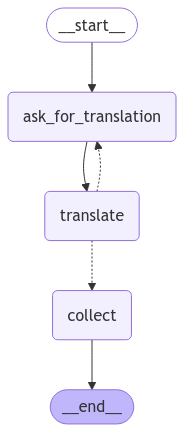

In [28]:
# 初始化 LLM 模型
llm = ChatOpenAI(model="deepseek-chat")

# 创建状态图
graph_builder = StateGraph(State)
graph_builder.add_node("ask_for_translation", ask_for_translation)
graph_builder.add_node("translate", translate)
graph_builder.add_node("collect", collect)

# 定义节点之间的流动关系
graph_builder.add_edge(START, "ask_for_translation")
graph_builder.add_edge("ask_for_translation", "translate")
graph_builder.add_conditional_edges("translate", route,
                                    {"ask_for_translation": "ask_for_translation",
                                     "collect": "collect"})
graph_builder.add_edge("collect", END)

# 编译状态图
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 展示翻译结果

In [29]:
inputs = {"num": 0, "translated_splits": [], "messages": []}
result = graph.invoke(inputs, {"recursion_limit": 100})

In [30]:
from IPython.display import Markdown, display

display(Markdown(result["translated"]))

# 非结构化

本笔记本介绍了如何使用非结构化文档加载器来加载多种类型的文件。非结构化目前支持加载文本文件、PowerPoint、HTML、PDF、图片等文件。

有关在本地设置非结构化的更多说明，包括设置所需的系统依赖项，请参阅本指南。

## 概述

## 集成详情

| 类 | 包 | 本地 | 可序列化 | JS 支持 |
| --- | --- | --- | --- | --- |
| UnstructuredLoader | langchain_unstructured | ✅ | ❌ | ✅ |

## 加载器特性

| 源文档 | 延迟加载 | 原生异步支持 |
| --- | --- | --- |
| UnstructuredLoader | ✅ | ❌ |

## 设置

### 凭证

默认情况下，`langchain-unstructured` 安装的是一个较小的版本，需要将分区逻辑卸载到非结构化 API，这需要一个 API 密钥。如果您使用本地安装，则不需要 API 密钥。要获取您的 API 密钥，请访问此网站并获取 API 密钥，然后在下面的单元格中设置它：

```python
import getpass
import os
if "UNSTRUCTURED_API_KEY" not in os.environ:
    os.environ["UNSTRUCTURED_API_KEY"] = getpass.getpass(
        "Enter your Unstructured API key: "
    )
```

## 安装

### 常规安装

运行本笔记本的其余部分需要以下包。

```bash
# 安装包，兼容 API 分区
%pip install --upgrade --quiet langchain-unstructured unstructured-client unstructured "unstructured[pdf]" python-magic
```

### 本地安装

如果您希望在本地运行分区逻辑，您需要安装一组系统依赖项，如非结构化文档中所述。

例如，在 Mac 上，您可以使用以下命令安装所需的依赖项：

```bash
# 基础依赖项
brew install libmagic poppler tesseract
# 如果解析 xml / html 文档：
brew install libxml2 libxslt
```

您可以使用以下命令安装本地所需的 pip 依赖项：

```bash
pip install "langchain-unstructured[local]"
```

## 初始化
`UnstructuredLoader` 允许从多种不同类型的文件中加载数据。要详细了解 `unstructured` 包，请参阅其文档。在此示例中，我们展示了如何从文本文件和 PDF 文件中加载数据。

```python
from langchain_unstructured import UnstructuredLoader

file_paths = [
    "./example_data/layout-parser-paper.pdf",
    "./example_data/state_of_the_union.txt",
]
loader = UnstructuredLoader(file_paths)
```

### API 参考：UnstructuredLoader

#### 加载

```python
docs = loader.load()
docs[0]
```

```
INFO: pikepdf C++ to Python logger bridge initialized
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((16.34, 213.36), (16.34, 253.36), (36.34, 253.36), (36.34, 213.36)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': 'd3ce55f220dfb75891b4394a18bcb973'}, page_content='1 2 0 2')
```

```python
print(docs[0].metadata)
```

```python
{'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((16.34, 213.36), (16.34, 253.36), (36.34, 253.36), (36.34, 213.36)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': 'd3ce55f220dfb75891b4394a18bcb973'}
```

#### 延迟加载

```python
pages = []
for doc in loader.lazy_load():
    pages.append(doc)
pages[0]
```
```python
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((16.34, 213.36), (16.34, 253.36), (36.34, 253.36), (36.34, 213.36)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': 'd3ce55f220dfb75891b4394a18bcb973'}, page_content='1 2 0 2')
```

### 后处理

如果在提取后需要对非结构化元素进行后处理，可以在实例化 `UnstructuredLoader` 时通过 `post_processors` 参数传入一个 `str -> str` 函数的列表。这同样适用于其他 `Unstructured` 加载器。以下是一个示例：

```python
from langchain_unstructured import UnstructuredLoader
from unstructured.cleaners.core import clean_extra_whitespace

loader = UnstructuredLoader(
    "./example_data/layout-parser-paper.pdf",
    post_processors=[clean_extra_whitespace],
)
docs = loader.load()
docs[5:10]
```

### API 参考：UnstructuredLoader
```python
[Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((16.34, 393.9), (16.34, 560.0), (36.34, 560.0), (36.34, 393.9)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'parent_id': '89565df026a24279aaea20dc08cedbec', 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': 'e9fa370aef7ee5c05744eb7bb7d9981b'}, page_content='2 v 8 4 3 5 1 . 3 0 1 2 : v i X r a'), 
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((157.62199999999999, 114.23496279999995), (157.62199999999999, 146.5141628), (457.7358962799999, 146.5141628), (457.7358962799999, 114.23496279999995)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'Title', 'element_id': 'bde0b230a1aa488e3ce837d33015181b'}, page_content='LayoutParser: A Uniﬁed Toolkit for Deep Learning Based Document Image Analysis'), 
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((134.809, 168.64029940800003), (134.809, 192.2517444), (480.5464199080001, 192.2517444), (480.5464199080001, 168.64029940800003)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'parent_id': 'bde0b230a1aa488e3ce837d33015181b', 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': '54700f902899f0c8c90488fa8d825bce'}, page_content='Zejiang Shen1 ((cid:0)), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain Lee4, Jacob
```
```markdown
Carlson3, and Weining Li5'), 
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((207.23000000000002, 202.57205439999996), (207.23000000000002, 311.8195408), (408.12676, 311.8195408), (408.12676, 202.57205439999996)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'page_number': 1, 'parent_id': 'bde0b230a1aa488e3ce837d33015181b', 'filetype': 'application/pdf', 'category': 'UncategorizedText', 'element_id': 'b650f5867bad9bb4e30384282c79bcfe'}, page_content='1 Allen Institute for AI shannons@allenai.org 2 Brown University ruochen zhang@brown.edu 3 Harvard University {melissadell,jacob carlson}@fas.harvard.edu 4 University of Washington bcgl@cs.washington.edu 5 University of Waterloo w422li@uwaterloo.ca'), 
Document(metadata={'source': './example_data/layout-parser-paper.pdf', 'coordinates': {'points': ((162.779, 338.45008160000003), (162.779, 566.8455408), (454.0372021523199, 566.8455408), (454.0372021523199, 338.45008160000003)), 'system': 'PixelSpace', 'layout_width': 612, 'layout_height': 792}, 'file_directory': './example_data', 'filename': 'layout-parser-paper.pdf', 'languages': ['eng'], 'last_modified': '2024-02-27T15:49:27', 'links': [{'text': ':// layout - parser . github . io', 'url': 'https://layout-parser.github.io', 'start_index': 1477}], 'page_number': 1, 'parent_id': 'bde0b230a1aa488e3ce837d33015181b', 'filetype': 'application/pdf', 'category': 'NarrativeText', 'element_id': 'cfc957c94fe63c8fd7c7f4bcb56e75a7'}, page_content='Abstract. Recent advances in document image analysis (DIA) have been primarily driven by the application of neural networks. Ideally, research outcomes could be easily deployed in production and extended for further investigation. However, various factors like loosely organized codebases and sophisticated model configurations
```
```markdown
使得重要创新难以被广泛受众轻松复用。尽管在自然语言处理和计算机视觉等领域已经有一些持续的努力来提升可复用性并简化深度学习（DL）模型的开发，但这些工具都没有针对文档图像分析（DIA）领域的挑战进行优化。这代表了现有工具包中的一个重大缺口，因为DIA在社会科学和人文学科的广泛学术研究中占据核心地位。本文介绍了LayoutParser，这是一个开源库，旨在简化DL在DIA研究和应用中的使用。LayoutParser核心库提供了一组简单直观的接口，用于应用和定制DL模型以完成布局检测、字符识别以及许多其他文档处理任务。为了促进可扩展性，LayoutParser还集成了一个社区平台，用于共享预训练模型和完整的文档数字化流水线。我们展示了LayoutParser在真实用例中对轻量级和大规模数字化流水线都非常有帮助。该库可在[https://layout-parser.github.io](https://layout-parser.github.io)公开获取。
```
```markdown
# Unstructured API

如果你想快速上手并使用较小的包，并获取最新的分区功能，可以通过 `pip install unstructured-client` 和 `pip install langchain-unstructured` 来安装相关依赖。有关 `UnstructuredLoader` 的更多信息，请参考 [Unstructured 提供者页面](https://example.com)。

当你传入 `api_key` 并设置 `partition_via_api=True` 时，加载器将使用托管的 Unstructured 无服务器 API 处理你的文档。你可以在这里生成一个免费的 [Unstructured API 密钥](https://example.com)。

如果你想自托管 Unstructured API 或在本地运行，请查看 [这里的说明](https://example.com)。

```python
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path="example_data/fake.docx",
    api_key=os.getenv("UNSTRUCTURED_API_KEY"),
    partition_via_api=True,
)
docs = loader.load()
docs[0]
```

### API 参考：UnstructuredLoader

```plaintext
INFO: Preparing to split document for partition.
INFO: Given file doesn't have '.pdf' extension, so splitting is not enabled.
INFO: Partitioning without split.
INFO: Successfully partitioned the document.
```

```python
Document(
    metadata={
        'source': 'example_data/fake.docx',
        'category_depth': 0,
        'filename': 'fake.docx',
        'languages': ['por', 'cat'],
        'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
        'category': 'Title',
        'element_id': '56d531394823d81787d77a04462ed096'
    },
    page_content='Lorem ipsum dolor sit amet.'
)
```

你还可以通过 `UnstructuredLoader` 在单个 API 调用中批量处理多个文件。

```python
loader = UnstructuredLoader(
    file_path=["example_data/fake.docx", "example_data/fake-email.eml"],
    api_key=os.getenv("UNSTRUCTURED_API_KEY"),
    partition_via_api=True,
)
docs = loader.load()
print(docs[0].metadata["filename"], ": ", docs[0].page_content[:100])
print(docs[-1].metadata["filename"], ": ", docs[-1].page_content[:100])
```
```
```markdown
```plaintext
INFO: 准备对文档进行分区。
INFO: 给定文件的扩展名不是 '.pdf'，因此未启用拆分功能。
INFO: 不进行拆分，直接分区。
INFO: 成功对文档进行了分区。
INFO: 准备对文档进行分区。
INFO: 给定文件的扩展名不是 '.pdf'，因此未启用拆分功能。
INFO: 不进行拆分，直接分区。
INFO: 成功对文档进行了分区。
```

```output
fake.docx :  Lorem ipsum dolor sit amet.
fake-email.eml :  Violets are blue
```

# Unstructured SDK 客户端

使用 Unstructured API 进行分区依赖于 Unstructured SDK 客户端。

如果你想自定义客户端，则需要将 `UnstructuredClient` 实例传递给 `UnstructuredLoader`。以下示例展示了如何自定义客户端的功能，例如使用你自己的 `requests.Session()`、传递替代的 `server_url` 以及自定义 `RetryConfig` 对象。有关自定义客户端或 SDK 客户端接受的其他参数的更多信息，请参阅 [Unstructured Python SDK 文档](https://example.com) 和 [API 参数文档](https://example.com) 的客户端部分。请注意，所有 API 参数都应传递给 `UnstructuredLoader`。

**警告**：以下示例可能未使用最新版本的 `UnstructuredClient`，未来版本中可能会有破坏性更改。有关最新示例，请参阅 [Unstructured Python SDK 文档](https://example.com)。

```python
# 示例代码
```
```
```markdown
```python
import requests
from langchain_unstructured import UnstructuredLoader
from unstructured_client import UnstructuredClient
from unstructured_client.utils import BackoffStrategy, RetryConfig

client = UnstructuredClient(
    api_key_auth=os.getenv(
        "UNSTRUCTURED_API_KEY"
    ),  # 注意：客户端 API 参数是 "api_key_auth" 而不是 "api_key"
    client=requests.Session(),  # 定义你自己的 requests session
    server_url="https://api.unstructuredapp.io/general/v0/general",  # 定义你自己的 API URL
    retry_config=RetryConfig(
        strategy="backoff",
        retry_connection_errors=True,
        backoff=BackoffStrategy(
            initial_interval=500,
            max_interval=60000,
            exponent=1.5,
            max_elapsed_time=900000,
        ),
    ),  # 定义你自己的重试配置
)

loader = UnstructuredLoader(
    "./example_data/layout-parser-paper.pdf",
    partition_via_api=True,
    client=client,
    split_pdf_page=True,
    split_pdf_page_range=[1, 10],
)

docs = loader.load()
print(docs[0].metadata["filename"], ": ", docs[0].page_content[:100])
```

# API 参考

## UnstructuredLoader
```
```markdown
```plaintext
INFO: 准备拆分文档以进行分区。
INFO: 并发级别设置为 5
INFO: 拆分第 1 到 10 页（共 10 页）
INFO: 确定最佳拆分大小为 2 页。
INFO: 分区 5 个文件，每个文件 2 页。
INFO: 分区第 1 组（第 1-2 页）。
INFO: 分区第 2 组（第 3-4 页）。
INFO: 分区第 3 组（第 5-6 页）。
INFO: 分区第 4 组（第 7-8 页）。
INFO: 分区第 5 组（第 9-10 页）。
INFO: HTTP 请求: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP 请求: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP 请求: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP 请求: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: 成功分区第 1 组，元素已添加到最终结果中。
INFO: 成功分区第 2 组，元素已添加到最终结果中。
INFO: 成功分区第 3 组，元素已添加到最终结果中。
INFO: 成功分区第 4 组，元素已添加到最终结果中。
INFO: 成功分区第 5 组，元素已添加到最终结果中。
INFO: 成功分区文档。
```

```plaintext
layout-parser-paper.pdf :  LayoutParser: 基于深度学习的文档图像分析统一工具包
分块​
UnstructuredLoader 不支持像旧版加载器 UnstructuredFileLoader 和其他加载器那样使用 mode 参数来分组文本。相反，它支持“分块”。在 unstructured 中，分块与您可能熟悉的其他分块机制不同，这些机制基于纯文本特征（如 "\n\n" 或 "\n" 等字符序列）来形成块，这些字符序列可能表示段落边界或列表项边界。相反，所有文档都使用特定于每种文档格式的知识进行拆分，将文档划分为语义单元（文档元素），只有当单个元素超过所需的最大块大小时，我们才需要求助于文本拆分。通常，
```
```
```markdown
分块将连续的元素组合在一起，形成尽可能大的块，而不会超过最大块大小。分块生成一系列 `CompositeElement`、`Table` 或 `TableChunk` 元素。每个“块”都是这三种类型之一的实例。

有关分块选项的更多详细信息，请参阅[此页面](https://example.com)，但要重现与 `mode="single"` 相同的行为，可以设置 `chunking_strategy="basic"`、`max_characters=<some-really-big-number>` 和 `include_orig_elements=False`。

```python
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    "./example_data/layout-parser-paper.pdf",
    chunking_strategy="basic",
    max_characters=1000000,
    include_orig_elements=False,
)
docs = loader.load()
print("Number of LangChain documents:", len(docs))
print("Length of text in the document:", len(docs[0].page_content))
```

**API 参考:** `UnstructuredLoader`

```plaintext
Number of LangChain documents: 1
Length of text in the document: 42772
```

### 加载网页​

`UnstructuredLoader` 在本地运行时接受 `web_url` 参数，该参数会填充底层 `Unstructured` 分区的 `url` 参数。这允许解析远程托管的文档，例如 HTML 网页。

**示例用法:**

```python
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(web_url="https://www.example.com")
docs = loader.load()
for doc in docs:
    print(f"{doc}\n")
```

**API 参考:** `UnstructuredLoader`
```
```markdown
```plaintext
page_content='Example Domain' metadata={'category_depth': 0, 'languages': ['eng'], 'filetype': 'text/html', 'url': 'https://www.example.com', 'category': 'Title', 'element_id': 'fdaa78d856f9d143aeeed85bf23f58f8'}
page_content='This domain is for use in illustrative examples in documents. You may use this domain in literature without prior coordination or asking for permission.' metadata={'languages': ['eng'], 'parent_id': 'fdaa78d856f9d143aeeed85bf23f58f8', 'filetype': 'text/html', 'url': 'https://www.example.com', 'category': 'NarrativeText', 'element_id': '3652b8458b0688639f973fe36253c992'}
page_content='More information...' metadata={'category_depth': 0, 'link_texts': ['More information...'], 'link_urls': ['https://www.iana.org/domains/example'], 'languages': ['eng'], 'filetype': 'text/html', 'url': 'https://www.example.com', 'category': 'Title', 'element_id': '793ab98565d6f6d6f3a6d614e3ace2a9'}
```

### API 参考​

有关 `UnstructuredLoader` 所有功能和配置的详细文档，请访问 API 参考：[https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html](https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html)

### 相关内容​
```
```markdown
# 文档加载器概念指南

# 文档加载器操作指南
```